In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import pandas as pd

# Read the dataset

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/One Dimensional CNN Tensor Flow

/content/drive/MyDrive/Course Material/Supervised Machine Learning/One Dimensional CNN Tensor Flow


In [44]:
data = pd.read_csv('Heterogeneous_accelerometer_HAR.csv')
data.shape

(3540962, 10)

In [45]:
data.head()

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand


# Check the null values

In [46]:
data.isnull().any()

Index            False
Arrival_Time     False
Creation_Time    False
x                False
y                False
z                False
User             False
Model            False
Device           False
gt                True
dtype: bool

In [47]:
data.dropna(inplace = True)

In [48]:
data.isnull().any()

Index            False
Arrival_Time     False
Creation_Time    False
x                False
y                False
z                False
User             False
Model            False
Device           False
gt               False
dtype: bool

# Select the relevant columns

In [49]:
har = data[['x','y','z','gt']]

In [50]:
har.head()

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand


In [51]:
har['gt'].unique()

array(['stand', 'sit', 'walk', 'stairsup', 'stairsdown', 'bike'],
      dtype=object)

# Extarct first 500 samples for each class

In [52]:
stand = har[har['gt'] == 'stand']

In [53]:
stand.head()

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand


In [54]:
stand = stand.iloc[0:500,:]

In [55]:
stand.shape

(500, 4)

In [56]:
sit = har[har['gt'] == 'sit'].iloc[0:500,:]

In [ ]:
sit.head()

In [ ]:
sit.shape

In [57]:
walk = har[har['gt'] == 'walk'].iloc[0:500,:]

In [58]:
stairsup = har[har['gt'] == 'stairsup'].iloc[0:500,:]

In [59]:
stairsdown = har[har['gt'] == 'stairsdown'].iloc[0:500,:]

In [60]:
bike = har[har['gt'] == 'bike'].iloc[0:500,:]

# Create a dataset with 500 samples for each class

In [61]:
harnew = pd.concat([stand, sit, walk, stairsup, stairsdown, bike])

In [62]:
harnew.shape

(3000, 4)

In [63]:
harnew

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand
...,...,...,...,...
27728,-8.280347,-0.789488,5.668871,bike
27729,-8.469488,-0.770933,5.674857,bike
27730,-8.678981,-0.626084,5.809530,bike
27731,-8.397662,-0.755969,5.509656,bike


# Convert Labels into integers

In [64]:
harnew['gt'].replace(to_replace = 'stand', value = 0, inplace = True)
harnew['gt'].replace(to_replace = 'sit', value = 1, inplace = True)
harnew['gt'].replace(to_replace = 'walk', value = 2, inplace = True)
harnew['gt'].replace(to_replace = 'stairsup', value = 3, inplace = True)
harnew['gt'].replace(to_replace = 'stairsdown', value = 4, inplace = True)
harnew['gt'].replace(to_replace = 'bike', value = 5, inplace = True)

In [65]:
harnew

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,0
1,-0.832584,-9.713276,-0.606930,0
2,-1.018134,-9.935339,-0.544082,0
3,-1.222838,-10.142437,-0.566229,0
4,-1.577180,-10.480618,-0.402824,0
...,...,...,...,...
27728,-8.280347,-0.789488,5.668871,5
27729,-8.469488,-0.770933,5.674857,5
27730,-8.678981,-0.626084,5.809530,5
27731,-8.397662,-0.755969,5.509656,5


# Function for data preparation



In [66]:
def data_preparing(df,  winSize):
    X, y = list(), list()
    for i in range(len(df) - winSize):
        features = df.iloc[:,:-1].values
        target = df.iloc[:,-1].values
        X_i = features[i:i+winSize]
        Y_i = target[i+winSize-1]
        X.append(X_i)
        y.append(Y_i)
    return array(X), array(y)

# Apply function on data

In [67]:
channels = 3 # this is number of channels
winSize = 100 # this is number of timesteps

X, y = data_preparing(harnew, winSize)
print(X.shape, y.shape)

(2900, 100, 3) (2900,)


# Perform train test split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [69]:
X_train.shape

(2320, 100, 3)

In [70]:
seqlen = X_train.shape[1]

# Creating the 1DCNN Model

In [71]:
i = Input(shape=(seqlen, channels))
x = Conv1D(64, 5, activation='relu')(i)
x = Conv1D(128, 2, activation='relu')(x)
x = Conv1D(256, 4, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6)(x)
model = Model(i, x)

# We can also create same model using Sequential() method

In [ ]:
# model = Sequential()
# model.add(Conv1D(64, kernel_size = 5, input_shape = (seqlen, channels)))
# model.add(Activation('relu'))
# model.add(Conv1D(128 ,kernel_size = 2))
# model.add(Activation('relu'))
# model.add(Conv1D(256 ,kernel_size = 4))
# model.add(Activation('relu'))
# model.add(MaxPooling1D(2))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(6))


In [72]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 64)            1024      
                                                                 
 conv1d_4 (Conv1D)           (None, 95, 128)           16512     
                                                                 
 conv1d_5 (Conv1D)           (None, 92, 256)           131328    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 46, 256)           0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                         

# See the Model Architecture

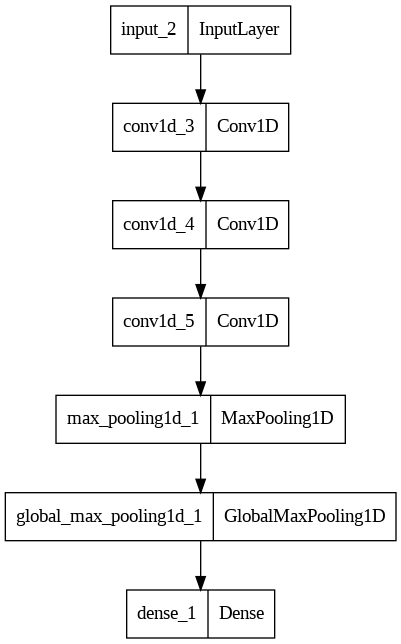

In [73]:
tf.keras.utils.plot_model(model)

# Compile the model

In [74]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

# Testing and Training

In [75]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= 20)

Epoch 1/20
73/73 [==============================] - 7s 81ms/step - loss: 0.3516 - accuracy: 0.8897 - val_loss: 0.0977 - val_accuracy: 0.9879
Epoch 2/20
73/73 [==============================] - 8s 110ms/step - loss: 0.1011 - accuracy: 0.9776 - val_loss: 0.0284 - val_accuracy: 0.9914
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0733 - accuracy: 0.9806 - val_loss: 0.0199 - val_accuracy: 0.9966
Epoch 4/20
73/73 [==============================] - 7s 96ms/step - loss: 0.0427 - accuracy: 0.9905 - val_loss: 0.0149 - val_accuracy: 0.9983
Epoch 5/20
73/73 [==============================] - 6s 79ms/step - loss: 0.0313 - accuracy: 0.9922 - val_loss: 0.0135 - val_accuracy: 0.9966
Epoch 6/20
73/73 [==============================] - 6s 77ms/step - loss: 0.0267 - accuracy: 0.9940 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 7/20
73/73 [==============================] - 8s 108ms/step - loss: 0.0201 - accuracy: 0.9953 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 8/20


In [76]:
trainAcc = [100 * x for x in hist.history['accuracy']]
testAcc = [100 * x for x in hist.history['val_accuracy']]

# Plotting and Visualizing the Results

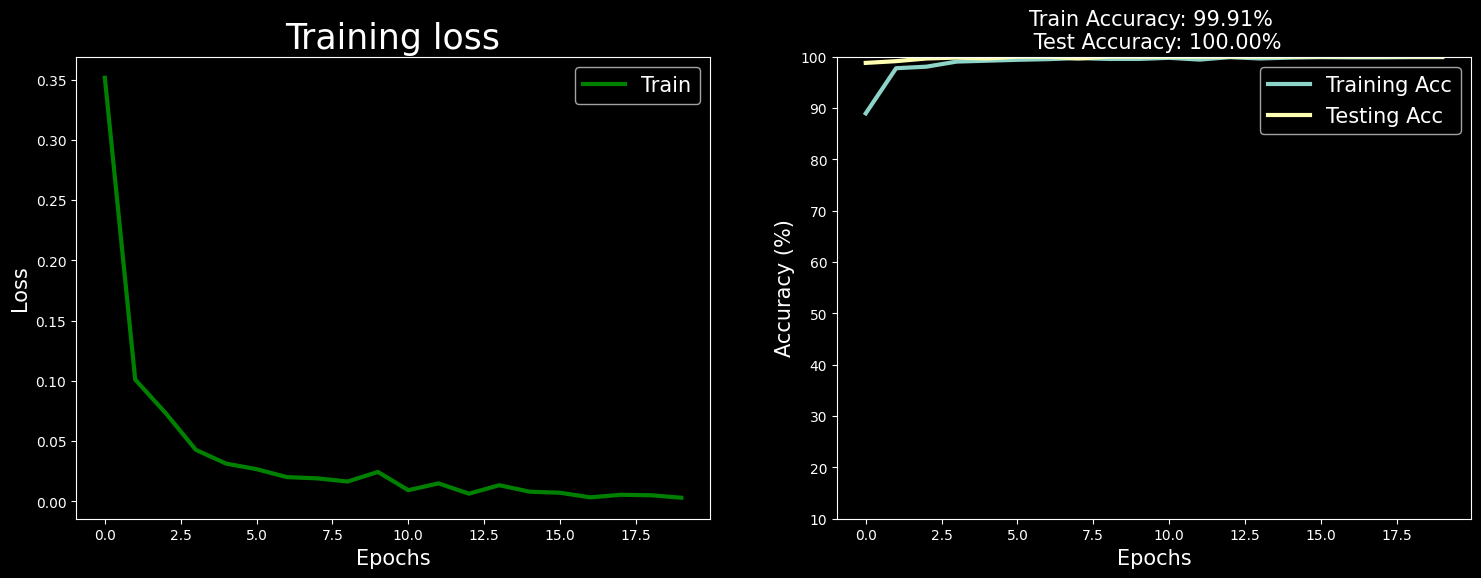

In [77]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(hist.history['loss'],'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()